In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import tables, math, os, sys, scipy
import healpy as hp
import matplotlib.pylab as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
sys.path.append('../')
from core.tools import *
from scipy.interpolate import splrep, splev

from core.tools import _trans
from core.progressbar.progressbar import ProgressBar 

In [4]:
from core.analysis_tools.public_pdfs import *
from core.analysis_tools.amtospheric_background import *
from core.analysis_tools.analysis import ReducedIntegratedSpatialTemplatePowerLawAnalysis
from core.analysis_tools.signal_pdfs import SinglePowerLaw
from core.analysis_tools.basic_spatial_templates import FullSky, NorthernHemisphere

In [5]:
effective_areas = EffectiveAreas()
energy_smearing = TrueEnergy2ReconstructedEnergySmearing(
    mc_path='/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')

In [6]:
phi100s = 10**np.linspace(-23,-17, 20)
gammas = np.arange(1.5,4.1,0.25)
signal_model = SinglePowerLaw(phi0_bins=phi100s, gamma_bins=gammas,
                             n_fitbins_phi0=150, n_fitbins_gamma=80)

In [7]:
gc_template = NorthernHemisphere() #FullSky()

In [8]:
atm_bckg = AtmosphericBackground()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


In [9]:
sindec_bins = np.linspace(-1,1,200)
ra_bins = np.linspace(0, np.pi*2, num=201)
log_ereco_bins = np.arange(2,7.1,0.2)

In [10]:
gc_ana = ReducedIntegratedSpatialTemplatePowerLawAnalysis(sindec_bins, ra_bins, log_ereco_bins,
                          energy_smearing=energy_smearing, 
                          atm_bckg=atm_bckg, effective_areas=effective_areas,
                          livetime=10., signal_model=signal_model, 
                          spatial_template=gc_template)

# Show the template (Full sky, so not really interesting here)

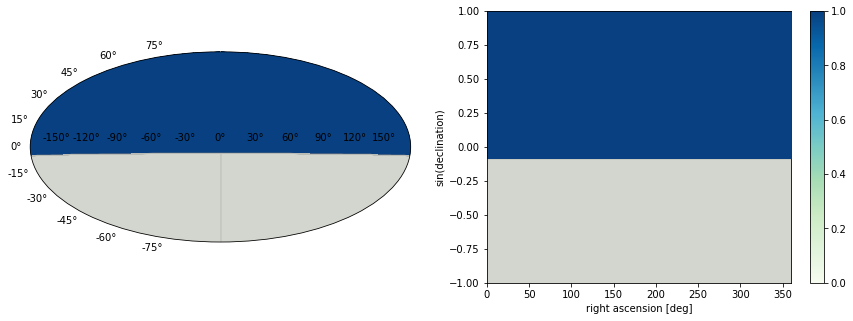

In [11]:
fig = plt.figure(figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0], projection="hammer")
ax2 = fig.add_subplot(spec[1])

lon, lat = _trans(gc_ana.ra_bins,np.arcsin(gc_ana.sindec_bins))

skymap = gc_ana._spatial_template_mask


ax.pcolormesh(lon,lat, skymap.T, cmap='GnBu')
ax.fill_between(np.rad2deg(gc_ana.ra_bins), -np.pi/2*np.ones_like(gc_ana.ra_bins), 
                np.ones_like(gc_ana.ra_bins)*np.deg2rad(-5.),
                color='grey', alpha=0.3)



p=ax2.pcolormesh(np.rad2deg(gc_ana.ra_bins),gc_ana.sindec_bins, skymap.T, 
                  cmap='GnBu')
ax2.fill_between(np.rad2deg(gc_ana.ra_bins), -np.ones_like(gc_ana.ra_bins), 
                 np.ones_like(gc_ana.ra_bins)*np.sin(np.deg2rad(-5.)),
                color='grey', alpha=0.3)

ax2.set_xlabel('right ascension [deg]')
ax2.set_ylabel('sin(declination)')

fig.colorbar(p, ax=ax2)

# Show the integrated event rates vs reconstructed energy

[==========================================================] 100% ELT 0h:00m:10s


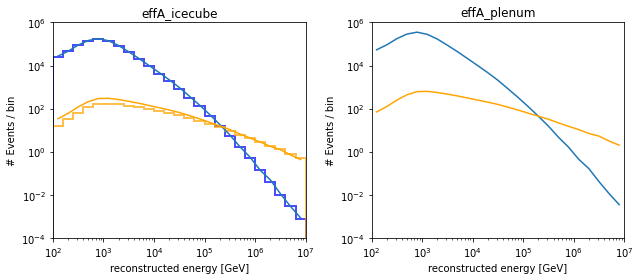

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = gc_ana._generate_background_expectation('numu_conv', astro_bckg=False)

params = [1.44e-18, 2.28]
d_sig = gc_ana._generate_signal_expectation(params)
for k,exp_key in enumerate(d_bckg.keys()):

    ax =axes[k]
    ax.set_title(exp_key)

    db = d_bckg[exp_key]
    ds = d_sig[exp_key][0]
    
    ax.plot(gc_ana.ereco_mids, db)
    ax.plot(gc_ana.ereco_mids, ds, color='orange')
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')
    
    
    if 'icecube' in exp_key:
    
        idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')

        w = (idata['conv']+idata['prompt'])*gc_ana.lt #* idata['trueE']**(-gamma)
        ax.hist(10**(idata['logE']), bins=gc_ana.ereco_bins, weights=w, color='blue',
                label=r'Atm. $\nu_{\mu}$', linewidth=2., histtype='step', alpha=0.7)

        w = (idata['astro'])*gc_ana.lt #* idata['trueE']**(-gamma)
        ax.hist(10**(idata['logE']), bins=gc_ana.ereco_bins, weights=w, color='orange',
                label=r'Astro', linewidth=2., histtype='step', alpha=0.7)

fig.tight_layout()



# Do some background trials 

In [13]:
bckg_trials = gc_ana.do_trials(n_trials=1000, 
                               bckg_kwargs =dict(atm_keys=['numu_conv'], 
                                                 astro_bckg=False),
                              integrate=True)

In [14]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.373
0.382


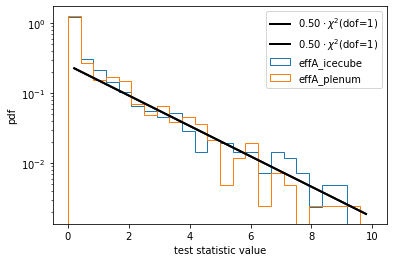

In [15]:
fig, ax = plt.subplots()

ts_bins = np.linspace(0,10,25)
for exp_key, trials in bckg_trials.items():
    ax.hist(trials['ts'], bins=ts_bins, histtype='step', label=exp_key, 
            density=True)
    
    eta = np.sum(trials['ts']<=0.1) / float(len(trials))
    print(eta)
    xvals = get_mids(ts_bins)
    fit_func = delta_chi2(eta=0.5, df=2.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=1)')
    
ax.set_xlabel('test statistic value')
ax.set_ylabel('pdf')

ax.legend()
ax.set_yscale('log')



# Do some trials with injected signal to check if it can be recovered


In [33]:
phi0_exp, gamma_exp = 1.44e-18, 2.28
n_trials = int(1e3)

N = 60
pbar = ProgressBar(N,parent=None).start()
for k in range(N):

    if k ==0:
        inj_trials = gc_ana.do_trials(n_trials=n_trials, signal_kwargs={'params':[phi0_exp, gamma_exp]},
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False),
                              integrate=True)
    else:
        inj_i = gc_ana.do_trials(n_trials=n_trials, signal_kwargs={'params':[phi0_exp, gamma_exp]},
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False),
                              integrate=True)
        for exp_key in inj_trials.keys():
            inj_trials[exp_key] = np.append(inj_trials[exp_key], 
                               inj_i[exp_key] )
    pbar.increment()

pbar.finish()

[==========================================================] 100% ELT 0h:08m:53s


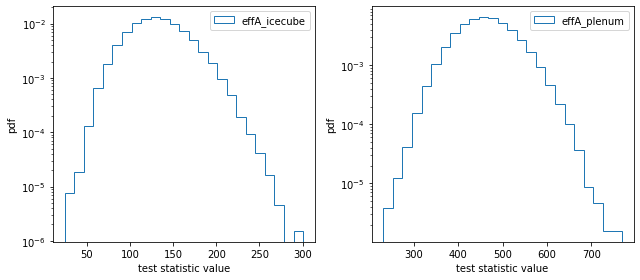

In [34]:
fig, axes = plt.subplots(ncols=2,figsize=(9,4))


for k, (exp_key, trials) in enumerate(inj_trials.items()):
    ax = axes[k]
    h,ts_bins, _= ax.hist(trials['ts'],bins=25, histtype='step', label=exp_key, 
            density=True)
    
    #print(exp_key, np.median(trials['ts']))
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('test statistic value')
    ax.set_ylabel('pdf')
    
fig.tight_layout()

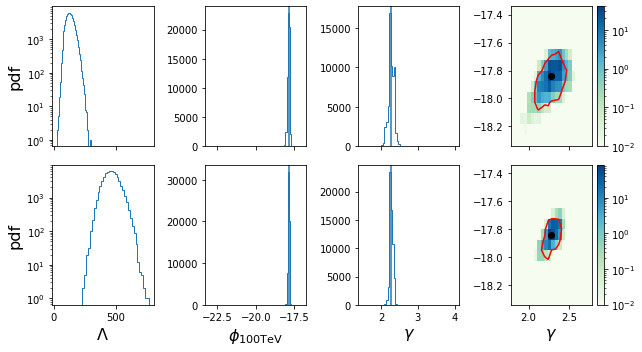

In [42]:
fs=16
fig, axes = plt.subplots(ncols=4,nrows=2,  figsize=(9,5.), sharex='col')

for k, (exp_key,trials) in enumerate(inj_trials.items()):
    
    ################# ts values #######################
    ax = axes[k, 0]
    bins = np.linspace(0,25, 35)
    ax.hist(trials['ts'], bins=35, histtype='step')
    ax.set_yscale('log')
    if k==1:
        ax.set_xlabel(r'$\Lambda$', fontsize=fs)
    ax.set_ylabel(r'pdf', fontsize=fs)
    
    
    ################# phi0 values #######################
    ax = axes[k, 1]
    bins_phi0 = np.linspace(np.log10(phi100s)[0], np.log10(phi100s)[-1], 80)
    ax.hist(np.log10(trials['phi0']), bins=bins_phi0, histtype='step')
    
    ax.axvline(np.log10(phi0_exp))
    if k==1:
        ax.set_xlabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    
    ################# gamma values #######################
    ax = axes[k, 2]
    bins_g = np.linspace(gammas[0], gammas[-1], 60)
    ax.hist(trials['gamma'], bins=bins_g, histtype='step')
    ax.axvline(gamma_exp)
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    
    
    ################# 2d phi0-gamma values #######################
    ax = axes[k, 3]
    
    p = np.histogram2d(trials['gamma'], np.log10(trials['phi0']),
              bins=(bins_g, bins_phi0),  normed=True)
    
    
    p[0][p[0]<1e-3] = 1e-3
    p0=ax.pcolormesh(get_mids(p[1]), get_mids(p[2]), p[0].T, 
                  cmap='GnBu', norm=LogNorm(), vmin=1e-2)#, shading='gouraud')
    
    fig.colorbar(p0, ax=ax)
    
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    #ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    #fig.colorbar(p[3], ax=ax)
    
    
    # add the contours etc
    
    unc_mat = p[0].flatten()
    X = np.empty((len(unc_mat), ), dtype=[('idx',int), ('p',float)])
    X['idx'] = np.arange(len(unc_mat))
    X['p'] = unc_mat / np.sum(unc_mat) 

    X = np.sort(X,order='p')
    X['p'] = np.cumsum(X['p'])
    X = np.sort(X, order='idx')

    Unc_mat = np.copy(X['p'])

    
    ax.contour(get_mids(p[1]), get_mids(p[2]), Unc_mat.reshape(p[0].shape).T * 100., levels=[5. ], 
                   linestyles = [ 'solid'], colors=['red'])
    

    ax.scatter([gamma_exp], [np.log10(phi0_exp)], marker='o', color='black',
              zorder=10)
    
    ax.set_xlim(gamma_exp-0.5, gamma_exp+0.5)
    ax.set_ylim(np.log10(phi0_exp)-0.5, np.log10(phi0_exp)+0.5)
    
fig.tight_layout()

# Show both contours in one plot

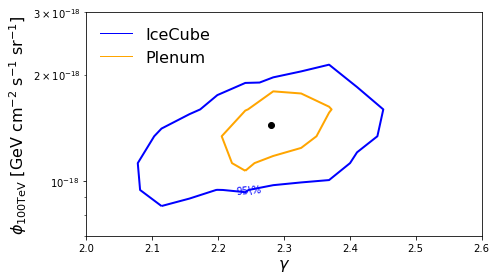

In [45]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots( figsize=(7,4.))

colors= ['blue', 'orange']
labels = {'icecube':'IceCube', 'plenum':'Plenum'}
#for k, exp in enumerate(['icecube', 'plenum']):
for k, (exp_key,trials) in enumerate(inj_trials.items()):
    p = np.histogram2d(trials['gamma'], np.log10(trials['phi0']),
              bins=(bins_g, bins_phi0),  normed=True)
    
    
    
    
    #if 'plenum' in exp_key:
    #    p[0][p[0]<1e-4] = 1e-4
    #    p0=ax.pcolormesh(get_mids(bins_g), 10**get_mids(bins_phi0), p[0].T, 
    #              cmap='GnBu', norm=LogNorm(), vmin=1e-3, shading='gouraud')
    
    #    fig.colorbar(p0, ax=ax)
    
    
    # add the contours etc
    
    unc_mat = p[0].flatten()
    X = np.empty((len(unc_mat), ), dtype=[('idx',int), ('p',float)])
    X['idx'] = np.arange(len(unc_mat))
    X['p'] = unc_mat / np.sum(unc_mat) 

    X = np.sort(X,order='p')
    X['p'] = np.cumsum(X['p'])
    X = np.sort(X, order='idx')

    Unc_mat = np.copy(X['p'])
    
    if 'icecube' in exp_key:
        level=5.
    else: 
        level=5.
    cs= ax.contour(get_mids(bins_g), 10**get_mids(bins_phi0), Unc_mat.reshape(p[0].shape).T * 100., levels=[level ], 
                   linestyles = [ 'solid'], colors=[colors[k]],  linewidths=[2.])
    
    
    ax.clabel(cs, inline=0, fontsize=10, inline_spacing=0., fmt={5.:'95\%'})
    
    # Now add the contour of the diffuse for comparison
    def get_diff(x,y, x0,y0):
        return np.sqrt((x-x0)**2 + (y-y0)**2)
    dpath = '/Users/mhuber/Documents/PHD_Thesis/PHD_thesis/resources/data/'
    diff95 = np.genfromtxt(os.path.join(dpath, 'diffuse95.csv'),delimiter=',')
    diff68 = np.genfromtxt(os.path.join(dpath, 'diffuse68.csv'),delimiter=',')


    cs = { 'Through-going tracks': 'pink'}
    styles = ['solid', 'dashed']
    data = { 'Through-going tracks': [diff95]}
    for key, val in data.items():

        for j, valj in enumerate(val):
            dg = valj[:,0]
            phi100 = valj[:,1]

            ind = np.zeros_like(phi100, dtype=int)
            for i in range(len(ind)):
                if i==0:
                    continue
                diff = get_diff(dg, np.log10(phi100), dg[ind[i-1]], np.log10(phi100[ind[i-1]]))
                inds = np.argsort(diff)
                for k in range(100):
                    if not inds[k] in ind:
                        ind[i] = inds[k]
                        break

            ind = np.append(ind, [0])    
            #ax.plot(dg[ind], phi100[ind]*1e-18, color=cs[key], marker='None',  lw=2, 
            #        ls=styles[j], alpha=0.8)



handles, labels = ax.get_legend_handles_labels()
icecube = Line2D(range(1), range(1), color=colors[0],  markerfacecolor="None",
             linewidth=1, label='IceCube')
plenum = Line2D(range(1), range(1), color=colors[1],  markerfacecolor="None",
              linewidth=1, label='Plenum')

handles.append(icecube)
handles.append(plenum)

    
    
    
ax.set_xlabel(r'$\gamma$', fontsize=fs)
ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=fs)
      
    
ax.legend(handles=handles,loc='upper left', frameon=False, fontsize=fs)
ax.set_xlim(2, 2.6)
ax.set_ylim(7e-19, 3e-18)
    
ax.set_yscale('log')
ax.scatter([gamma_exp], [phi0_exp], marker='o', color='black',
              zorder=10)
    
fig.tight_layout()

fig.savefig('../plots/diffuse_analysis_physics_parameter_contour.png', dpi=200)